In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import joblib

# 1. Data Loading and Preparation
def load_time_series_data():
    """Load data where each test has one time series of temperatures"""
    summary_df = pd.read_csv('all_time.csv')
    test_data = []
    
    # Load each test file and its parameters
    for i in range(1, 26):
        try:
            filename = f'csv_ave/{i}_ave.csv'
            df = pd.read_csv(filename, header=1)
            test_params = summary_df.iloc[i-1][['Fb_set\n[kN]', 'v_set\n[km/h]', 'μ_m', 't2\n[s]']].values #t2 is braking time
            temperature_series = df.iloc[:, 3].values  # Assuming temperature is in column 3
            
            test_data.append({
                'Fb_set': test_params[0],
                'v_set': test_params[1],
                'μ_m': test_params[2],
                't2': test_params[3],
                'temperature_series': temperature_series,
                'series_length': len(temperature_series)
            })
        except FileNotFoundError:
            continue
    
    return test_data

# Load data
test_data = load_time_series_data()

# Find the maximum length to pad/truncate all series to same length
max_length = max([d['series_length'] for d in test_data])

# Prepare data arrays
X = []
y = []

for test in test_data:
    # Input features, t2 is braking time
    X.append([test['Fb_set'], test['v_set'], test['μ_m'], test['t2']])
    
    # Temperature series (pad shorter series with last value)
    temp_series = test['temperature_series']
    if len(temp_series) < max_length:
        padded = np.pad(temp_series, 
                       (0, max_length - len(temp_series)), 
                       mode='edge')  # Pad with last value
    else:
        padded = temp_series[:max_length]  # Truncate if longer
    y.append(padded)

X = np.array(X)
y = np.array(y)

In [20]:
print(X.shape)
print(y.shape)

(12, 4)
(12, 43663)


In [21]:
print(X)

[[ 23.     50.      0.408  12.   ]
 [ 23.     80.      0.383  22.1  ]
 [ 23.    120.      0.374  35.7  ]
 [ 23.    160.      0.376  49.1  ]
 [ 23.    200.      0.381  61.8  ]
 [ 23.    250.      0.383  78.4  ]
 [ 23.     50.      0.397  12.5  ]
 [ 23.     80.      0.379  22.4  ]
 [ 23.    120.      0.38   35.3  ]
 [ 23.    160.      0.387  47.8  ]
 [ 23.    200.      0.396  60.   ]
 [ 23.    250.      0.392  76.8  ]]


In [22]:
# Split into train and test sets (keeping each test's series together)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

# Normalize features
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# Normalize targets (per time step)
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# 2. Model Definition
def build_time_series_model(input_shape, output_length):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=input_shape),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(8, activation='relu'),
        layers.Dense(output_length)  # Output matches time series length
    ])
    
    optimizer = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
    return model

model = build_time_series_model((X_train.shape[1],), max_length)
model.summary()

# 3. Training Configuration
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True)

checkpoint = ModelCheckpoint(
    'best_time_series_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min')

# 4. Train the Model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping, checkpoint],
    verbose=1)

/Users/yanjun/Documents/apps/miniconda3/envs/dd2421/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 43663)          │       392,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 395,631 (1.51 MB)

 Trainable params: 395,631 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - loss: 0.9154 - mae: 0.8160

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - loss: 0.9154 - mae: 0.8160 - val_loss: 1.3436 - val_mae: 1.0615
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9139 - mae: 0.8152 - val_loss: 1.3488 - val_mae: 1.0609
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.9127 - mae: 0.8147 - val_loss: 1.3546 - val_mae: 1.0597
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9100 - mae: 0.8131 - val_loss: 1.3582 - val_mae: 1.0568
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.9015 - mae: 0.8091 - val_loss: 1.3586 - val_mae: 1.0513
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9030 - mae: 0.8093 - val_loss: 1.3548 - val_mae: 1.0436
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.9012 - mae: 0.8086 - val_loss: 1.3488 - val_mae: 1.0346
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8953 - mae: 0.8085

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.8953 - mae: 0.8085 - val_loss: 1.3401 - val_mae: 1.0239
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8954 - mae: 0.8077

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.8954 - mae: 0.8077 - val_loss: 1.3291 - val_mae: 1.0118
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8898 - mae: 0.8075

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.8898 - mae: 0.8075 - val_loss: 1.3148 - val_mae: 0.9966
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8686 - mae: 0.8009

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.8686 - mae: 0.8009 - val_loss: 1.2969 - val_mae: 0.9778
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8484 - mae: 0.7861

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.8484 - mae: 0.7861 - val_loss: 1.2740 - val_mae: 0.9526
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8790 - mae: 0.8001

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.8790 - mae: 0.8001 - val_loss: 1.2528 - val_mae: 0.9270
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8368 - mae: 0.7870

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.8368 - mae: 0.7870 - val_loss: 1.2270 - val_mae: 0.8969
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8512 - mae: 0.7913

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.8512 - mae: 0.7913 - val_loss: 1.1997 - val_mae: 0.8673
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9277 - mae: 0.8179

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.9277 - mae: 0.8179 - val_loss: 1.1804 - val_mae: 0.8532
Epoch 17/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8324 - mae: 0.7678

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.8324 - mae: 0.7678 - val_loss: 1.1589 - val_mae: 0.8396
Epoch 18/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8163 - mae: 0.7630

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.8163 - mae: 0.7630 - val_loss: 1.1367 - val_mae: 0.8251
Epoch 19/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8189 - mae: 0.7706

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.8189 - mae: 0.7706 - val_loss: 1.1101 - val_mae: 0.8036
Epoch 20/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7919 - mae: 0.7283

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7919 - mae: 0.7283 - val_loss: 1.0799 - val_mae: 0.7868
Epoch 21/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8333 - mae: 0.7456

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.8333 - mae: 0.7456 - val_loss: 1.0373 - val_mae: 0.7689
Epoch 22/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7812 - mae: 0.7430

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.7812 - mae: 0.7430 - val_loss: 0.9874 - val_mae: 0.7482
Epoch 23/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7453 - mae: 0.7258

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.7453 - mae: 0.7258 - val_loss: 0.9232 - val_mae: 0.7202
Epoch 24/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7623 - mae: 0.7483

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7623 - mae: 0.7483 - val_loss: 0.8486 - val_mae: 0.6839
Epoch 25/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6878 - mae: 0.7029

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6878 - mae: 0.7029 - val_loss: 0.7657 - val_mae: 0.6285
Epoch 26/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7921 - mae: 0.7174

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.7921 - mae: 0.7174 - val_loss: 0.6785 - val_mae: 0.5925
Epoch 27/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7514 - mae: 0.7089

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.7514 - mae: 0.7089 - val_loss: 0.5997 - val_mae: 0.5714
Epoch 28/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7264 - mae: 0.6739

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.7264 - mae: 0.6739 - val_loss: 0.5316 - val_mae: 0.5601
Epoch 29/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7091 - mae: 0.7064

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7091 - mae: 0.7064 - val_loss: 0.4965 - val_mae: 0.5743
Epoch 30/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6153 - mae: 0.6122 - val_loss: 0.4997 - val_mae: 0.6079
Epoch 31/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6835 - mae: 0.6160 - val_loss: 0.5366 - val_mae: 0.6517
Epoch 32/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6336 - mae: 0.6507 - val_loss: 0.5522 - val_mae: 0.6650
Epoch 33/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7031 - mae: 0.6524 - val_loss: 0.5870 - val_mae: 0.6909
Epoch 34/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6533 - mae: 0.6487 - val_loss: 0.6816 - val_mae: 0.7526
Epoch 35/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5291 - mae: 0.5954 - val_loss: 0.7590 - val_mae: 0.7958
Epoch 36/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5360 - mae: 0.5401 - val_loss: 0.8311 - val_mae: 0.8361
Epoch 37/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5558 - mae: 0.61


Evaluating on test data:
Test MSE: 6.0455, Test MAE: 1.3695
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/Users/yanjun/Documents/apps/miniconda3/envs/dd2421/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


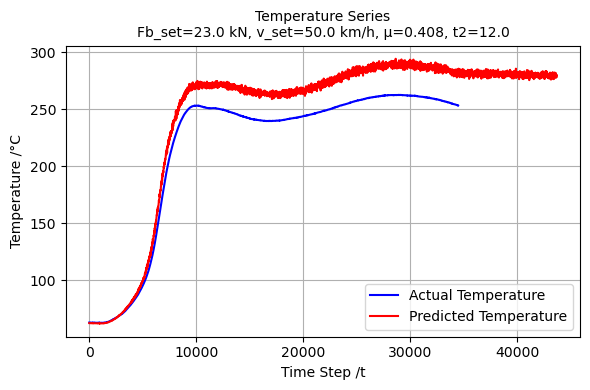

In [33]:
# 5. Evaluate the Model
print("\nEvaluating on test data:")
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Save the model and scalers
model.save('brake_temp_time_series_model.keras')
joblib.dump(scaler_X, 'scaler_X_time_series.pkl')
joblib.dump(scaler_y, 'scaler_y_time_series.pkl')

# 6. Prediction Function
def predict_temperature_series(Fb_set, v_set, mu_m, t2):
    """Predict the full temperature time series for given parameters"""
    # Load model and scalers
    model = keras.models.load_model('brake_temp_time_series_model.keras')
    scaler_X = joblib.load('scaler_X_time_series.pkl')
    scaler_y = joblib.load('scaler_y_time_series.pkl')
    
    # Prepare input
    input_data = np.array([[Fb_set, v_set, mu_m, t2]])
    input_data = scaler_X.transform(input_data)
    
    # Predict
    prediction = model.predict(input_data)
    prediction = scaler_y.inverse_transform(prediction)
    
    return prediction[0]  # Return the full time series

# 7. Visualization
def plot_temperature_series(Fb_set, v_set, mu_m, t2):
    """Plot the predicted temperature series"""
    # Get prediction
    pred_temp = predict_temperature_series(Fb_set, v_set, mu_m, t2)
    
    # Find the actual data if available
    actual_temp = None
    for test in test_data:
        if (test['Fb_set'] == Fb_set and 
            test['v_set'] == v_set and 
            test['μ_m'] == mu_m and
            test['t2'] == t2 ):
            actual_temp = test['temperature_series']
            break
    
    # Create time axis
    time_steps = np.arange(len(pred_temp))/t2
    
    # Plot
    font_size1=10
    plt.figure(figsize=(6, 4))
    t2_i = int(t2)

    time_actual = np.arange(len(actual_temp))[::t2_i]
    temp_actual = actual_temp[::t2_i]
    if actual_temp is not None:
        plt.plot(time_actual, temp_actual, 'b-', label='Actual Temperature')

    time_pred = np.arange(len(pred_temp))[::t2_i]
    temp_pred = pred_temp[::t2_i]

    plt.plot(time_pred, temp_pred, 'r-', label='Predicted Temperature')

    
    plt.title(f'Temperature Series\nFb_set={Fb_set} kN, v_set={v_set} km/h, μ={mu_m}, t2={t2}',fontsize=font_size1)
    plt.xlabel('Time Step /t',fontsize=font_size1)
    plt.ylabel('Temperature /°C',fontsize=font_size1)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('temperature.pdf')
    plt.show()
    

# Example usage
if len(test_data) > 0:
    sample_test = test_data[0]
    plot_temperature_series(sample_test['Fb_set'], 
                            sample_test['v_set'], 
                            sample_test['μ_m'],
                            sample_test['t2'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/Users/yanjun/Documents/apps/miniconda3/envs/dd2421/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


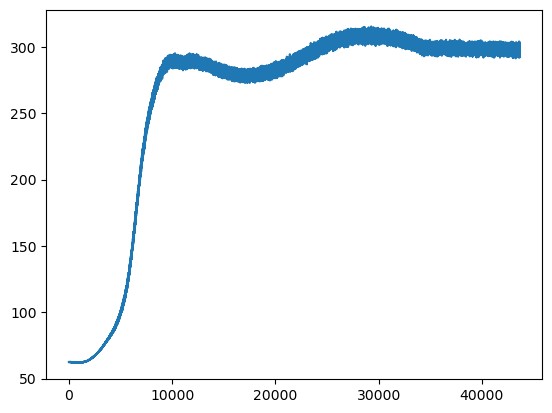

In [12]:
model = keras.models.load_model('brake_temp_time_series_model.keras')
scaler_X = joblib.load('scaler_X_time_series.pkl')
scaler_y = joblib.load('scaler_y_time_series.pkl')

# here 5 is initial velocity, 5 km/h suppose has lower temperature while this model has higer temperature,
# this is wrong
x = [23, 5, 0.408, 2]  
#input_data = np.array([[Fb_set, v_set, mu_m, t2]])
input_data = scaler_X.transform(np.array([x]))
    
# Predict
prediction = model.predict(input_data)
prediction = scaler_y.inverse_transform(prediction)
    
y = prediction[0]  # Return the full time series
plt.plot(y)
